In [1]:
%reload_ext autoreload
%autoreload 2

import os
import pickle
import logging
import multiprocessing
from pathlib import Path

import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp

import arviz as az
import numpyro

from hbmep.config import Config
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

logger = logging.getLogger(__name__)

In [2]:
import numpyro.distributions as dist
from hbmep.model import Baseline


class RectifiedLogistic(Baseline):
    LINK = "rectified_logistic"

    def __init__(self, config: Config):
        super(RectifiedLogistic, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]

    def _model(self, subject, features, intensity, response_obs=None):
        subject, n_subject = subject
        features, n_features = features
        intensity, n_data = intensity

        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)
        n_feature0 = n_features[0]
        n_baseline = 1
        n_delta = 1

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_baseline", n_baseline, dim=-2):
                mu_a_baseline = numpyro.sample("mu_a_baseline", dist.HalfNormal(scale=50))

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_baseline", n_baseline, dim=-2):
                mu_a_delta = numpyro.sample("mu_a_delta", dist.Normal(loc=0, scale=1000))

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            global_sigma_b = numpyro.sample("global_sigma_b", dist.HalfNormal(100))
            global_sigma_v = numpyro.sample("global_sigma_v", dist.HalfNormal(100))

            global_sigma_L = numpyro.sample("global_sigma_L", dist.HalfNormal(1))
            global_sigma_l = numpyro.sample("global_sigma_l", dist.HalfNormal(100))
            global_sigma_H = numpyro.sample("global_sigma_H", dist.HalfNormal(5))

            global_sigma_g_1 = numpyro.sample("global_sigma_g_1", dist.HalfNormal(100))
            global_sigma_g_2 = numpyro.sample("global_sigma_g_2", dist.HalfNormal(100))

            global_sigma_p = numpyro.sample("global_sigma_p", dist.HalfNormal(100))

            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                """ Hyper-priors """
                # mu_a = numpyro.sample(site.mu_a, dist.HalfNormal(scale=50))
                mu_a = numpyro.deterministic(
                    site.mu_a,
                    jnp.concatenate([mu_a_baseline, mu_a_baseline + mu_a_delta], axis=0)
                )

                sigma_a = numpyro.sample(site.sigma_a, dist.HalfNormal(scale=1 / 50))

                sigma_b_raw = numpyro.sample("sigma_b_raw", dist.HalfNormal(scale=1))
                sigma_b = numpyro.deterministic(site.sigma_b, global_sigma_b * sigma_b_raw)

                sigma_v_raw = numpyro.sample("sigma_v_raw", dist.HalfNormal(scale=1))
                sigma_v = numpyro.deterministic(site.sigma_v, global_sigma_v * sigma_v_raw)

                sigma_L_raw = numpyro.sample("sigma_L_raw", dist.HalfNormal(scale=1))
                sigma_L = numpyro.deterministic(site.sigma_L, global_sigma_L * sigma_L_raw)

                sigma_l_raw = numpyro.sample("sigma_l_raw", dist.HalfNormal(scale=1))
                sigma_l = numpyro.deterministic("sigma_l", global_sigma_l * sigma_l_raw)

                sigma_H_raw = numpyro.sample("sigma_H_raw", dist.HalfNormal(scale=1))
                sigma_H = numpyro.deterministic(site.sigma_H, global_sigma_H * sigma_H_raw)

                sigma_g_1_raw = numpyro.sample("sigma_g_1_raw", dist.HalfNormal(scale=1))
                sigma_g_1 = numpyro.deterministic("sigma_g_1", global_sigma_g_1 * sigma_g_1_raw)

                sigma_g_2_raw = numpyro.sample("sigma_g_2_raw", dist.HalfNormal(scale=1))
                sigma_g_2 = numpyro.deterministic("sigma_g_2", global_sigma_g_2 * sigma_g_2_raw)

                sigma_p_raw = numpyro.sample("sigma_p_raw", dist.HalfNormal(scale=1))
                sigma_p = numpyro.deterministic("sigma_p", global_sigma_p * sigma_p_raw)

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Priors """
                    a_raw = numpyro.sample("a_raw", dist.Gamma(concentration=mu_a * sigma_a, rate=1))
                    a = numpyro.deterministic(site.a, (1 / sigma_a) * a_raw)

                    b_raw = numpyro.sample("b_raw", dist.HalfNormal(scale=1))
                    b = numpyro.deterministic(site.b, sigma_b * b_raw)

                    v_raw = numpyro.sample("v_raw", dist.HalfNormal(scale=1))
                    v = numpyro.deterministic(site.v, sigma_v * v_raw)

                    L_raw = numpyro.sample("L_raw", dist.HalfNormal(scale=1))
                    L = numpyro.deterministic(site.L, sigma_L * L_raw)

                    l_raw = numpyro.sample("l_raw", dist.HalfNormal(scale=1))
                    l = numpyro.deterministic("l", sigma_l * l_raw)

                    H_raw = numpyro.sample("H_raw", dist.HalfNormal(scale=1))
                    H = numpyro.deterministic(site.H, sigma_H * H_raw)

                    g_1_raw = numpyro.sample("g_1_raw", dist.HalfCauchy(scale=1))
                    g_1 = numpyro.deterministic(site.g_1, sigma_g_1 * g_1_raw)

                    g_2_raw = numpyro.sample("g_2_raw", dist.HalfCauchy(scale=1))
                    g_2 = numpyro.deterministic(site.g_2, sigma_g_2 * g_2_raw)

                    p_raw = numpyro.sample("p_raw", dist.HalfNormal(scale=1))
                    p = numpyro.deterministic("p", sigma_p * p_raw)

        """ Penalty """
        mu_a_penalty = (jnp.fabs(mu_a_baseline + mu_a_delta) - (mu_a_baseline + mu_a_delta))
        numpyro.factor("mu_a_penalty", -mu_a_penalty)

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate(site.data, n_data, dim=-2):
                """ Model """
                mu = numpyro.deterministic(
                    site.mu,
                    L[subject, feature0]
                    + jnp.where(
                        intensity <= a[subject, feature0],
                        0,
                        -l[subject, feature0]
                        + (
                            (H[subject, feature0] + l[subject, feature0])
                            / jnp.power(
                                1
                                + (
                                    (
                                        -1
                                        + jnp.power(
                                            (H[subject, feature0] + l[subject, feature0]) / l[subject, feature0],
                                            v[subject, feature0]
                                        )
                                    )
                                    * jnp.exp(-b[subject, feature0] * (intensity - a[subject, feature0]))
                                ),
                                1 / v[subject, feature0]
                            )
                        )
                    )
                )
                beta = numpyro.deterministic(
                    site.beta,
                    g_1[subject, feature0] + g_2[subject, feature0] * jnp.power(1 / (mu + 1), p[subject, feature0])
                )

                """ Observation """
                numpyro.sample(
                    site.obs,
                    dist.Gamma(concentration=mu * beta, rate=beta),
                    obs=response_obs
                )

        xmu = numpyro.sample("xmu", dist.Normal(loc=50, scale=100))
        xsigma = numpyro.sample("xsigma", dist.HalfNormal(100))
        ymu = numpyro.sample("ymu", dist.Normal(loc=50, scale=100))
        ysigma = numpyro.sample("ysigma", dist.HalfNormal(100))
        numpyro.sample("xobs", dist.Normal(loc=xmu, scale=xsigma), obs=a[8:, 0, 0])
        numpyro.sample("yobs", dist.Normal(loc=ymu, scale=ysigma), obs=a[:8, 1, 0])

        # with numpyro.plate("nx", nx, dim=-1):
        #     with numpyro.plate("nxsamples", nxsamples, dim=-2):
        #         numpyro.sample("xobs", dist.Normal(loc=xmu, scale=xsigma), obs=xsamples)

        # with numpyro.plate("ny", ny, dim=-1):
        #     with numpyro.plate("nysamples", nysamples, dim=-2):
        #         numpyro.sample("yobs", dist.Normal(loc=ymu, scale=ysigma), obs=ysamples)

In [3]:
# def fn(x, L, l, H, v, b, a):
#     return (
#         L
#         + jnp.where(
#             x <= a,
#             0.0,
#             -l
#             + (
#                 (H + l)
#                 / jnp.power(
#                     1
#                     + (
#                         (
#                             -1
#                             + jnp.power(
#                                 (H + l) / l,
#                                 v
#                             )
#                         )
#                         * jnp.exp(-b * (x - a))
#                     ),
#                     1 / v
#                 )
#             )
#         )
#     )

# params = {
#     "L": 1,
#     "l": 1,
#     "H": 1,
#     "v": 1,
#     "b": 1,
#     "a": 1,
# }
# params = (1., 1., 1., 1., 1., 1., 1.)
# print(fn(*params))
# print(jax.grad(fn)(*params))


In [4]:
toml_path = os.path.join("/home/vishu/repos/hbmep-paper/configs/paper/tms/link-comparison/proc-2023-10-27/injury/rectified_logistic.toml")
config = Config(toml_path=toml_path)

model = RectifiedLogistic(config=config)

# from numpyro.infer import NUTS
# sampler = NUTS(model=model._model, max_tree_depth=50)

# mcmc = az.from_netcdf("/home/vishu/repos/hbmep-paper/reports/paper/tms/link-comparison/proc-2023-10-27/rectified_logistic/numpyro_data.nc")
# posterior_samples = {
#     u: v.to_numpy().reshape(-1, *v.shape[2:]) for u, v in mcmc.posterior.items()
# }

2023-10-31 10:00:22,997 - hbmep.config - INFO - Verifying configuration ...
2023-10-31 10:00:22,997 - hbmep.config - INFO - Success!
2023-10-31 10:00:23,017 - hbmep.model.baseline - INFO - Initialized model with rectified_logistic link


In [5]:
src = "/home/vishu/data/hbmep-processed/human/tms/data_pkpk_auc_proc-2023-10-27.csv"
df = pd.read_csv(src)

injured = ["SCS02", "SCS04"]
uninjured = ["SCA01", "SCA04", "SCA05", "SCA06", "SCA07", "SCA09", "SCA10", "SCA11"]
subset = injured + uninjured
ind = df[model.subject].isin(subset)
df = df[ind].reset_index(drop=True).copy()

df, encoder_dict = model.load(df=df)


2023-10-31 10:00:23,101 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/paper/tms/link-comparison/proc-2023-10-27/injury
2023-10-31 10:00:23,101 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/paper/tms/link-comparison/proc-2023-10-27/injury
2023-10-31 10:00:23,102 - hbmep.dataset.core - INFO - Processing data ...
2023-10-31 10:00:23,103 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


Text(0.5, 1.0, '0.82725')

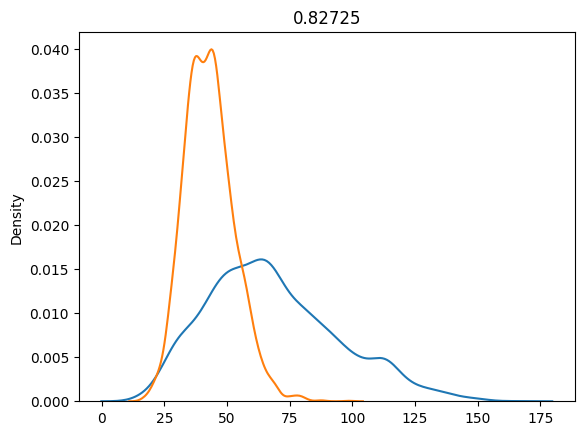

In [23]:
mu_a = np.array(posterior_samples[site.mu_a])
sns.kdeplot(mu_a[:, 0, 0])
sns.kdeplot(mu_a[:, 1, 0])
plt.title((mu_a[:, 1, 0] < mu_a[:, 0, 0]).mean())

Text(0.5, 1.0, '0.82725')

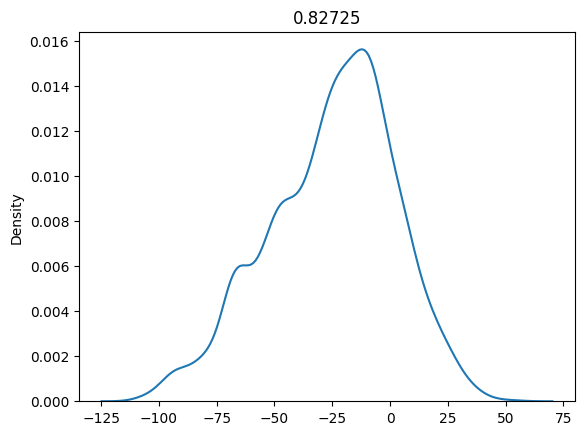

In [28]:
mu_a_delta = np.array(posterior_samples["mu_a_delta"])[..., 0, 0]
sns.kdeplot(mu_a_delta)
plt.title((mu_a_delta < 0).mean())

Text(0.5, 1.0, '0.8565')

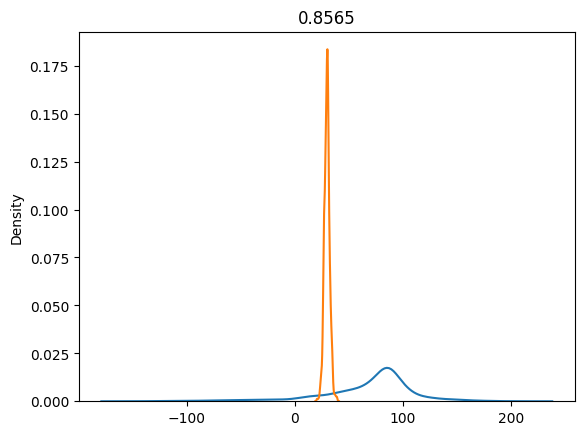

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.kdeplot(posterior_samples["xmu"])
sns.kdeplot(posterior_samples["ymu"])
plt.title((posterior_samples["ymu"] < posterior_samples["xmu"]).mean())

In [6]:
mcmc, posterior_samples = model.run_inference(df=df)


2023-10-31 10:00:23,186 - hbmep.model.baseline - INFO - Running inference with rectified_logistic ...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

2023-10-31 10:12:53,861 - hbmep.utils.utils - INFO - func:run_inference took: 12 min and 30.68 sec


In [7]:
a = np.array(posterior_samples["a"])
a.shape

(4000, 10, 2, 1)

In [ ]:
inj = a[..., 1:, 0, 0]
inj = inj.mean(axis=0)
inj



array([82.03497215])

In [ ]:
unj = a[..., :1, 1, 0]
unj = unj.mean(axis=0)
unj

array([35.09862104])

In [8]:
prediction_df = model.make_prediction_dataset(df=df)
posterior_predictive = model.predict(df=prediction_df, posterior_samples=posterior_samples)

model.render_recruitment_curves(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples, prediction_df=prediction_df, posterior_predictive=posterior_predictive)
model.render_predictive_check(df=df, encoder_dict=encoder_dict, prediction_df=prediction_df, posterior_predictive=posterior_predictive)


2023-10-31 10:14:45,093 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.01 sec


2023-10-31 10:14:47,104 - hbmep.utils.utils - INFO - func:predict took: 2.01 sec
2023-10-31 10:14:47,110 - hbmep.model.baseline - INFO - Rendering ...
2023-10-31 10:14:49,057 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/paper/tms/link-comparison/proc-2023-10-27/injury/recruitment_curves.pdf
2023-10-31 10:14:49,057 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 1.95 sec
2023-10-31 10:14:49,067 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-10-31 10:14:50,998 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/paper/tms/link-comparison/proc-2023-10-27/injury/posterior_predictive_check.pdf
2023-10-31 10:14:50,999 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 1.94 sec
2023-10-31 10:14:50,999 - hbmep.utils.utils - INFO - func:render_predictive_check took: 1.94 sec


In [11]:
mcmc.print_summary(prob=.95)



                         mean       std    median      2.5%     97.5%     n_eff     r_hat
       H_raw[0,0,0]      0.85      0.54      0.72      0.00      1.91    159.55      1.03
       H_raw[0,1,0]      0.73      0.50      0.58      0.07      1.71     75.61      1.05
       H_raw[1,0,0]      0.70      0.59      0.56      0.00      1.87     77.47      1.06
       H_raw[1,1,0]      0.79      0.62      0.67      0.01      2.00     66.78      1.06
       L_raw[0,0,0]      0.91      0.61      0.84      0.00      2.05    183.34      1.01
       L_raw[0,1,0]      0.39      0.41      0.25      0.00      1.30     69.56      1.03
       L_raw[1,0,0]      0.85      0.67      0.71      0.02      2.12     60.91      1.08
       L_raw[1,1,0]      0.73      0.60      0.60      0.00      1.95    112.62      1.07
       a_raw[0,0,0]      1.27      1.50      0.76      0.00      4.20    149.82      1.04
       a_raw[0,1,0]      0.62      0.46      0.50      0.02      1.52     44.76      1.12
       a_

Text(0.5, 1.0, '0.59175')

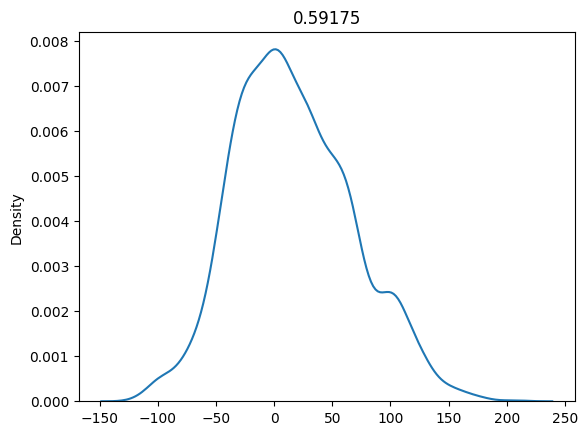

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

mu_a_delta = np.array(posterior_samples["mu_a_delta"])
mu_a_delta.shape

sns.kdeplot(mu_a_delta[:, 0, 0])
plt.title((mu_a_delta[:, 0, 0] > 0).mean())

<Axes: ylabel='Density'>

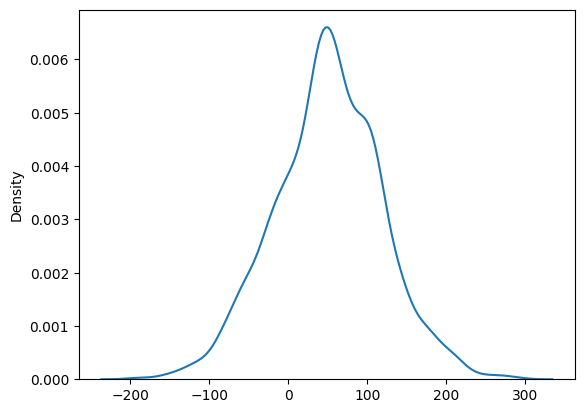

In [14]:
xmu = posterior_samples["xmu"]
ymu = posterior_samples["ymu"]

sns.kdeplot(xmu - ymu)

In [37]:
(loo.pareto_k.values > ).mean() * 100

48.484848484848484

In [54]:
len(numpyro_data.posterior.keys())

48

In [40]:
loo

Computed from 4000 posterior samples and 264 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   675.26    42.64
p_loo       41.29        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      256   97.0%
 (0.5, 0.7]   (ok)          2    0.8%
   (0.7, 1]   (bad)         3    1.1%
   (1, Inf)   (very bad)    3    1.1%

In [26]:
numpyro_data = az.from_numpyro(mcmc)
loo = az.loo(numpyro_data, var_name="obs")

/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [11]:
numpyro_data = az.from_numpyro(mcmc)

""" Model evaluation """
logger.info("Evaluating model ...")

score = az.loo(numpyro_data)
logger.info(f"ELPD LOO (Log): {score.elpd_loo:.2f}")

score = az.waic(numpyro_data)
logger.info(f"ELPD WAIC (Log): {score.elpd_waic:.2f}")


2023-10-30 14:06:44,619 - __main__ - INFO - Evaluating model ...


TypeError: Found several log likelihood arrays ['a_penalty', 'obs'], var_name cannot be None

In [ ]:
import pickle

dest = os.path.join(model.build_dir, "inference.pkl")
with open(dest, "wb") as f:
    pickle.dump((model, mcmc, posterior_samples), f)


In [ ]:
dest = os.path.join(model.build_dir, "numpyro_data.nc")
az.to_netcdf(numpyro_data, dest)


'/home/vishu/repos/hbmep-paper/reports/paper/tms/link-comparison/rectified_logistic/numpyro_data.nc'